Contents:
- 2D CNN GAN (MNIST, Fashion MNIST, CIFAR 10)

# Generative Adversarial Networks
Generative Adversarial Networks are composed of two models:

* The first model is called a Generator and it aims to generate new data similar to the expected one. The Generator could be similar to a human art forger, which creates fake works of art.

* The second model is named the Discriminator. This models’s goal is to recognize if an input data is ‘real‘–belongs to the original dataset–or if it is ‘fake‘–generated by a forger. In this scenario, a Discriminator is analogous to the police, which tries to detect artworks as truthful or fraud.

![GAN](GAN.jpeg "GAN")

It can be thought of the Generator as having an adversary, the Discriminator. The Generator needs to learn how to create data in such a way that the Discriminator isn’t able to distinguish it as fake anymore. The competition between these two teams is what improves their knowledge, until the Generator succeeds in creating realistic data.

## Mathematically Modelling a GAN
Though the GANs framework could be applied to any two models that perform the tasks described above, it is easier to understand when using universal approxiamators such as Artificial Neural Network (ANN).

A neural network G(z,θ1) is used to model the Generator mentioned above. It’s role is mapping input noise variables 
z to the desired data space x. Conversely, a second neural network D(x,θ2) models the discriminator and outputs the probability that the data came from the real dataset, in the range (0,1). In both cases, θi represents the weights or parameters that define each neural network.

As a result, the Discriminator is trained to correctly classify the input data as either real or fake. This means it’s weights are updated as to maximize the probability that any real data input x is classified as belonging to the real dataset, while minimizing the probability that any fake image is classified as belonging to the real dataset. In more technical terms, the loss/error function used maximizes the function D(x), and it also minimizes D(G(z)).

Furthermore, the Generator is trained to fool the Discriminator by generating data as realistic as possible, which means that the Generator’s weight’s are optimized to maximize the probability that any fake image is classified as belonging to the real dataset. Formally this means that the loss/error function used for this network maximizes D(G(z)).

In practice, the logarithm of the probability (e.g. logD(..)) is used in the loss functions instead of the raw probabilities, since using a log loss heavily penalizes classifiers that are confident about an incorrect classification.

After several steps of training, if the Generator and Discriminator have enough capacity, they will reach a point at which both cannot improve anymore. At this point, the generator generates realistic synthetic data, and the discriminator is unable to differentiate between the two types of input.

Since during training both the Discriminator and Generator are trying to optimize opposite loss functions, they can be thought of two agents playing a minimax game with value function V(G,D). In this minimax game, the generator is trying to maximize it’s probability of having it’s outputs recognized as real, while the discriminator is trying to minimize this same value.

$\underset{G}{\text{min}}\,\underset{D}{\text{max}}\, V(D,G) = \mathbb{E}_{x\sim P_{data} (x)} [\text{log} D(x)] + \mathbb{E}_{z\sim P_{z} (z)} [\text{log} (1-D(G(z)))]$

Since both the generator and discriminator are being modeled with neural network, a  gradient- based optimization algorithm can be used to train the GAN. In the coding example, we will be using stochastic gradient descent, as it has proven to be successful in multiple fields. The complete algorithms of original GAN is illustrated below.

![GAN Algorithm](gan_algorithm.png "GAN Algorithm")

# Python Implementation
The fundamental steps to train a GAN can be described as following:

* Sample a noise set and a real.data set, each with size m
* Train the Discriminator on this data.
* Sample a different noise subset with size m
* Train the Generator on this data.
* Repeat from step 1.

ref: http://cican17.com/gan-from-zero-to-hero-part-1/

In [1]:
import os
import numpy as np
from numpy.random import rand, randint, randn
from matplotlib import pyplot
from tqdm import tqdm
 
from keras.layers import Input, Conv2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist, fashion_mnist, cifar10
from keras.optimizers import Adam
from keras import initializers
 

Using TensorFlow backend.


In [2]:
np.random.seed(10)
random_dim = 100

In [3]:
# create and grid plot of multiple images
def grid_plot(examples, dimensions=(10, 10), figsize=(10, 10), cmap='gray_r'):
    pyplot.figure(figsize=figsize)
    for i in range(dimensions[0] * dimensions[1]):
        pyplot.subplot(dimensions[0], dimensions[1], 1 + i)
        pyplot.axis('off')
        pyplot.imshow(np.squeeze(examples[i]), interpolation='nearest', cmap=cmap)
    pyplot.tight_layout()
    pyplot.show()

## Load Real Data
We will create functions that will generate batches of our real data in the correct format.

In [4]:
def load_minst_data():
    # load the data
    (x_train, _), (_, _) = mnist.load_data()

    # expand to 3d, e.g. add channels dimension
    x_train = np.expand_dims(x_train, axis=-1)
    
    # scale from [0,255] to [0,1]
    x_train = x_train.astype(np.float32)
    x_train = x_train / 255.0
    
    # summarize the shape of the dataset
    print('Dataset shape:', x_train.shape)

    return x_train

In [5]:
def load_fashion_minst_data():
    # load the data
    (x_train, _), (_, _) = fashion_mnist.load_data()

    # expand to 3d, e.g. add channels dimension
    x_train = np.expand_dims(x_train, axis=-1)
    
    # scale from [0,255] to [0,1]
    x_train = x_train.astype(np.float32)
    x_train = x_train / 255.0
    
    # summarize the shape of the dataset
    print('Dataset shape:', x_train.shape)

    return x_train

In [6]:
def load_cifar10_data():
    # load the data
    (x_train, _), (_, _) = cifar10.load_data()
    
    # scale from [0,255] to [0,1]
    x_train = x_train.astype(np.float32)
    x_train = x_train / 255.0
    
    # summarize the shape of the dataset
    print('Dataset shape:', x_train.shape)

    return x_train

### Test
Visualise the output of the above for testing purposes

Dataset shape: (60000, 28, 28, 1)


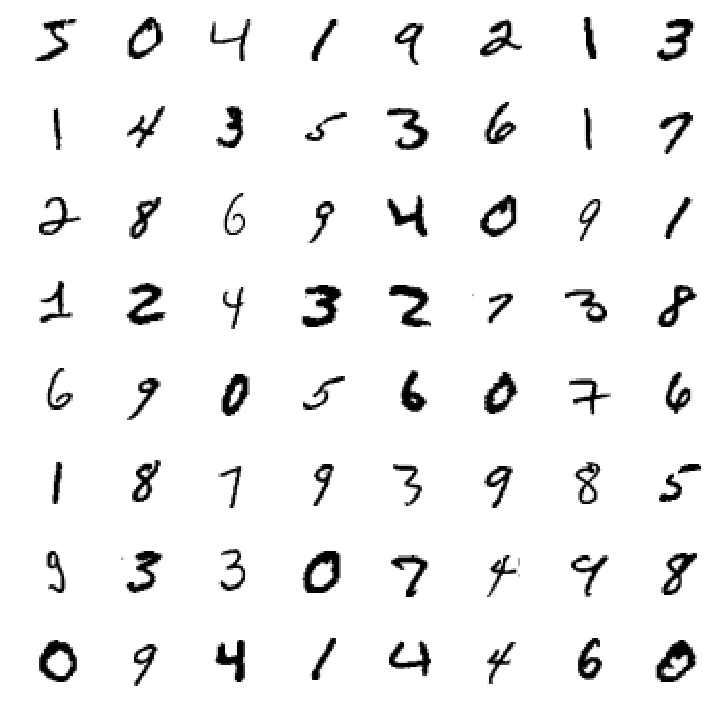

In [7]:
# plot images from the training dataset
X = load_minst_data()
grid_plot(X, dimensions=(8,8))

Dataset shape: (60000, 28, 28, 1)


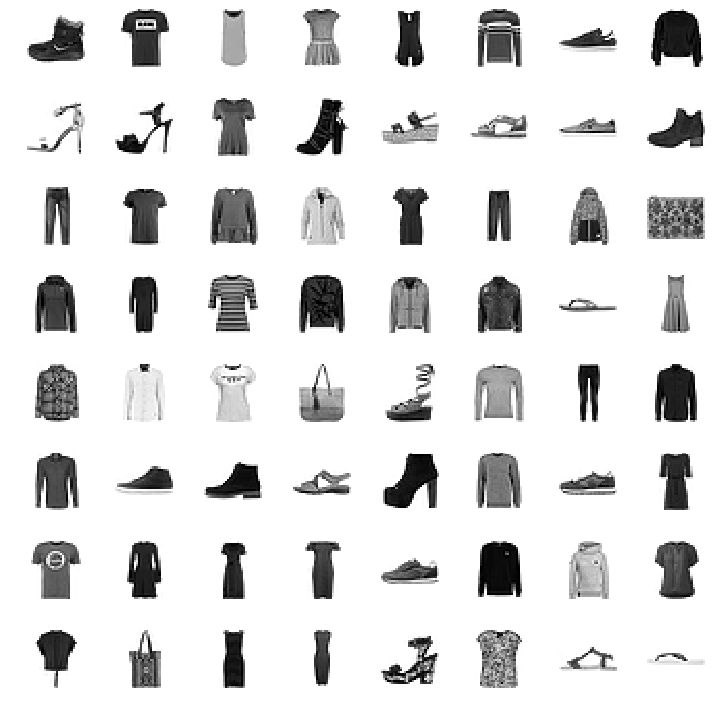

In [8]:
# plot images from the training dataset
X = load_fashion_minst_data()
grid_plot(X, dimensions=(8,8))

Dataset shape: (50000, 32, 32, 3)


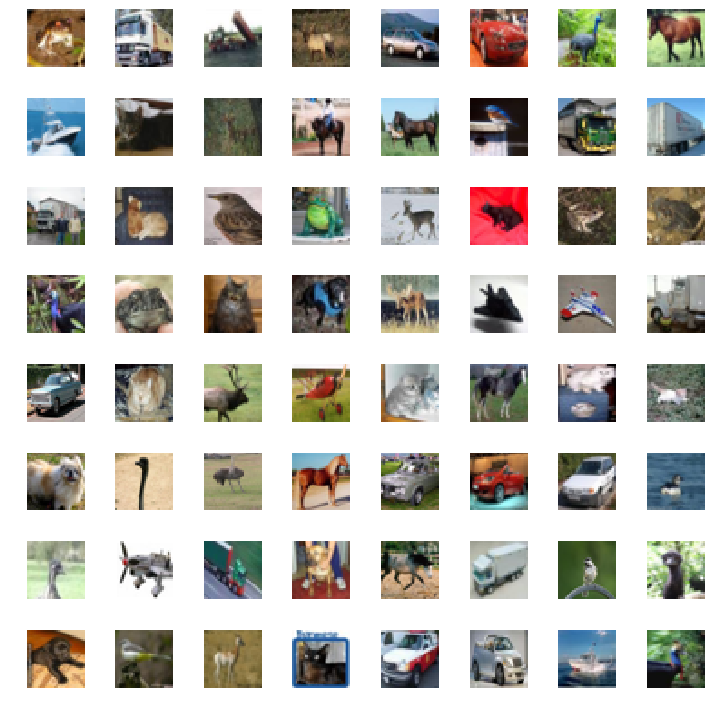

In [9]:
# plot images from the training dataset
X = load_cifar10_data()
grid_plot(X, dimensions=(8,8))

## Generate Real / Fake Data Samples
We will create functions that will generate batches of our real data in the correct format and with corresponging class labels.

In [10]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = np.ones((n_samples, 1))
    return X, y

In [11]:
# generate n fake samples with class labels
def generate_fake_noise_samples(shape, n_samples):
    # generate uniform random numbers in [0,1]
    X = rand(shape[0] * shape[1] * shape[2] * n_samples)
    
    # reshape into a batch of grayscale images
    X = X.reshape((n_samples, shape[0], shape[1], shape[2]))
    
    # generate 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

### Test
Visualise the output of the above for testing purposes (1 & 3 channel tests)

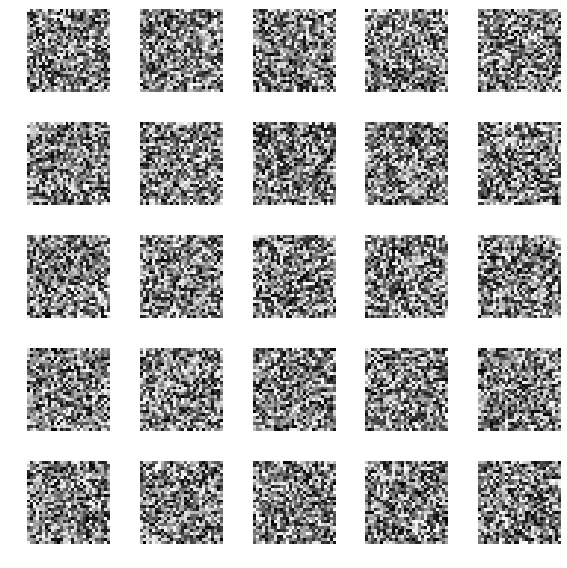

In [39]:
n_samples = 25
X, _ = generate_fake_noise_samples((28,28,1), n_samples)
grid_plot(X, dimensions=(5,5), figsize=(8,8))

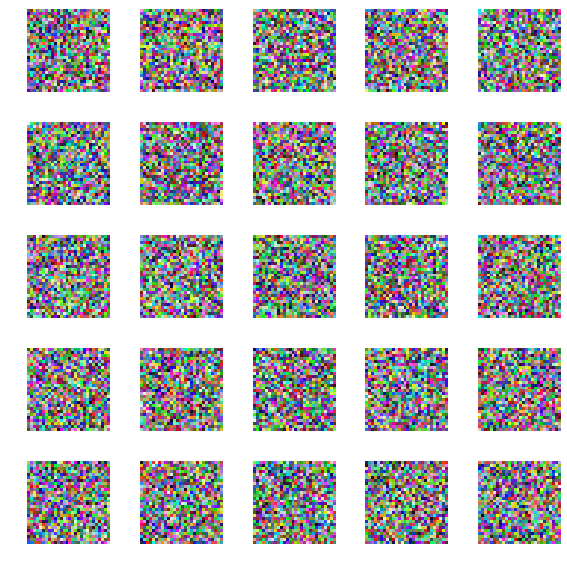

In [40]:
n_samples = 25
X, _ = generate_fake_noise_samples((28,28,3), n_samples)
grid_plot(X, dimensions=(5,5), figsize=(8,8))

## Discriminator Model
First we will define the discriminator. This network will take an image as its input, and return the probability of it belonging to the real dataset, or the synthetic dataset. Each followed is followed by a Leaky-ReLU nonlinearity and a Dropout layer to prevent overfitting. A sigmoid function is applied to the real-valued output to obtain a value in the open-range(0,1).

In [32]:
def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.5) 
 
# a simple feed forward model
def get_discriminator_FF(optimizer, in_shape=(28,28,1)):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return discriminator
 
# a convolutional model
def get_discriminator(optimizer, in_shape=(28,28,1)):
    discriminator = Sequential()
    discriminator.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Flatten())   
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return discriminator

# a deeper convolutional model
def get_discriminator_deeper(optimizer, in_shape=(32,32,3)):
    model = Sequential()
    # normal
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

### Test
Visualise the models

In [33]:
# define model
model = get_discriminator_FF(get_optimizer())
# summarize the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               131328    
__________

In [34]:
# define model
model = get_discriminator(get_optimizer())
# summarize the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 3136)              0         
__________

In [35]:
# define model
model = get_discriminator_deeper(get_optimizer())
# summarize the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_35 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 4, 4, 256)         295168    
__________

As a test, we can try training this part of the model with both real and fake samples as it is just a normal neural network for binary classification. 

NOTE: In an actual GAN we would not train the discriminator in this way.

In [50]:
# train the discriminator model
def train_discriminator(model, dataset, shape=(28,28,1), n_iter=100, n_batch=256):
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_iter):
        # get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)

        # update discriminator on real samples
        real_loss, real_acc = model.train_on_batch(X_real, y_real)

        # generate 'fake' examples
        X_fake, y_fake = generate_fake_noise_samples(shape, half_batch)

        # update discriminator on fake samples
        fake_loss, fake_acc = model.train_on_batch(X_fake, y_fake)

        # Summarise train performance
        if (i+1)%10 == 0:
            print('>%d real(loss,acc)=%f,%.0f%% fake(loss,acc)=%f,%.0f%%' % (i+1, real_loss, real_acc*100, fake_loss, fake_acc*100))

In [51]:
# fit the model
X = load_fashion_minst_data()
model = get_discriminator(get_optimizer())
train_discriminator(model, X)

Dataset shape: (60000, 28, 28, 1)
>10 real(loss,acc)=0.708822,35% fake(loss,acc)=0.575094,100%
>20 real(loss,acc)=0.701050,50% fake(loss,acc)=0.450149,100%
>30 real(loss,acc)=0.624021,76% fake(loss,acc)=0.323869,100%
>40 real(loss,acc)=0.446272,93% fake(loss,acc)=0.237478,100%
>50 real(loss,acc)=0.274450,98% fake(loss,acc)=0.137695,100%
>60 real(loss,acc)=0.167749,98% fake(loss,acc)=0.085620,100%
>70 real(loss,acc)=0.129559,97% fake(loss,acc)=0.058367,100%
>80 real(loss,acc)=0.087153,98% fake(loss,acc)=0.040465,100%
>90 real(loss,acc)=0.058419,99% fake(loss,acc)=0.030308,100%
>100 real(loss,acc)=0.041239,99% fake(loss,acc)=0.027928,100%


In [52]:
# fit the model
X = load_cifar10_data()
model = get_discriminator_deeper(get_optimizer())
train_discriminator(model, X, (32, 32, 3))

Dataset shape: (50000, 32, 32, 3)
>10 real(loss,acc)=0.718508,8% fake(loss,acc)=0.604609,100%
>20 real(loss,acc)=0.559499,84% fake(loss,acc)=0.168756,100%
>30 real(loss,acc)=0.037543,99% fake(loss,acc)=0.014109,100%
>40 real(loss,acc)=0.016575,99% fake(loss,acc)=0.002057,100%
>50 real(loss,acc)=0.016959,99% fake(loss,acc)=0.002198,100%
>60 real(loss,acc)=0.001255,100% fake(loss,acc)=0.001202,100%
>70 real(loss,acc)=0.001225,100% fake(loss,acc)=0.000909,100%
>80 real(loss,acc)=0.001406,100% fake(loss,acc)=0.001692,100%
>90 real(loss,acc)=0.005242,100% fake(loss,acc)=0.000836,100%
>100 real(loss,acc)=0.000220,100% fake(loss,acc)=0.000315,100%


## Generator Model
On the other hand, the Generative Network takes a latent variable vector as input, and returns an output image. Remember that the purpose of this network is to learn how to create indistinguishable images of clothes images, which is why its output is a new image.


Note that the model is not compiled as the generator model is not fit directly. The weights in the generator model are updated based on the performance of the discriminator model in the GAN.

In [71]:
# a simple FF generator model
def get_generator_FF(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    # 784 valued vector, which corresponds to a flattened 28×28 image
    # sigmoid to get values in range 0..1 which reflects our image scaling.
    generator.add(Dense(784, activation='sigmoid'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

# a basic cnn generator model
def get_generator(latent_dim):
    generator = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    generator.add(Dense(n_nodes, input_dim=latent_dim))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(Reshape((7, 7, 128)))
    # upsample to 14x14
    generator.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    generator.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    generator.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return generator

# a deeper cnn generator model
def get_generator_deeper(latent_dim):
    model = Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Conv2D(3, (3,3), activation='sigmoid', padding='same'))
    return model

We also create a function that will generate random points in latent space, and a function that will use the generator to generate output ('fake') samples based upon random samples within the latent space as the input.

In [72]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# use the generator to generate n fake examples and plot the results
def generate_generator_prediction_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = np.zeros((n_samples, 1))
    return X, y

### Test
Visualise the model

In [73]:
# size of the latent space
latent_dim = 5
# define the generator model
generator = get_generator(latent_dim)
# summarize the model
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 6272)              37632     
_________________________________________________________________
leaky_re_lu_85 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
reshape_13 (Reshape)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_29 (Conv2DT (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_86 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_30 (Conv2DT (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_87 (LeakyReLU)   (None, 28, 28, 128)       0         
__________

If we run the above now, we will see a fairly random outputs as the generator has not been trained (1 & 3 channel tests). 

When we train it we would expect it to more closely match the real samples

(25, 28, 28, 1)


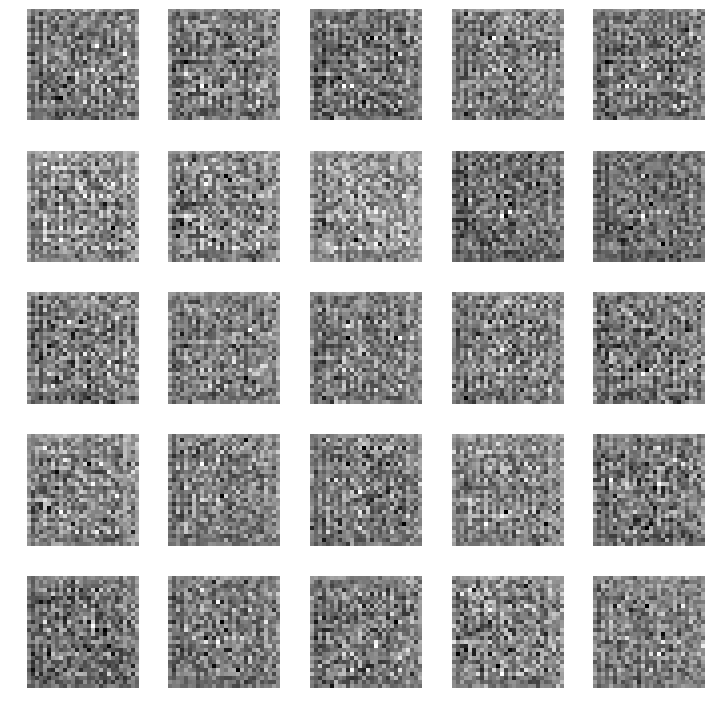

In [74]:
X, _ = generate_generator_prediction_samples(generator, latent_dim=latent_dim, n_samples=25)
print(X.shape)
grid_plot(X, dimensions=(5,5))

Visualise the deeper model

In [75]:
# size of the latent space
latent_dim = 100
# define the generator model
generator = get_generator_deeper(latent_dim)
# summarize the model
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu_88 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
reshape_14 (Reshape)         (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_31 (Conv2DT (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_89 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_32 (Conv2DT (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_90 (LeakyReLU)   (None, 16, 16, 128)       0         
__________

If we run the above now, we will see a fairly random outputs as the generator has not been trained (1 & 3 channel tests). 

When we train it we would expect it to more closely match the real samples

(25, 32, 32, 3)


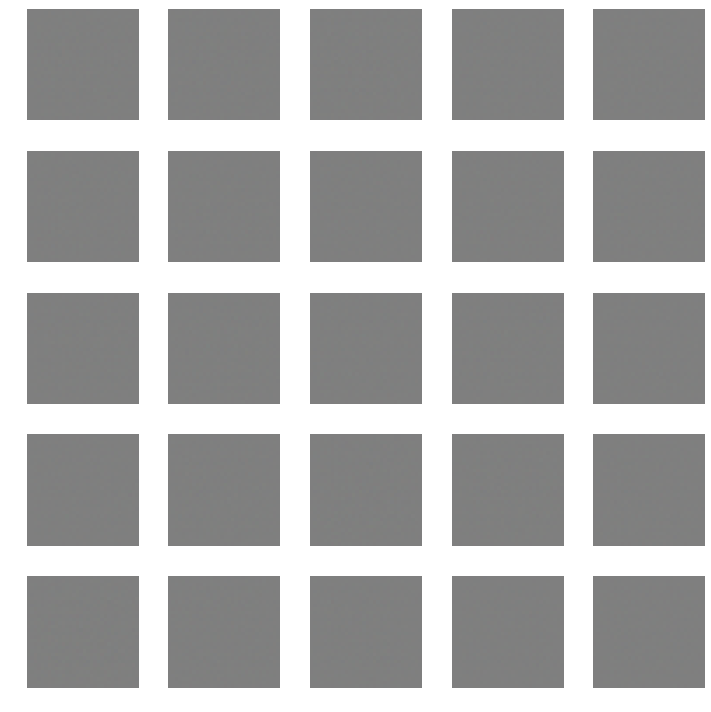

In [77]:
X, _ = generate_generator_prediction_samples(generator, latent_dim=latent_dim, n_samples=25)
print(X.shape)
grid_plot(X, dimensions=(5,5))

## Create GAN
When we train the GAN model, the weights in the generator model are updated based on the performance of the discriminator model. When the discriminator is good at detecting fake samples, the generator is updated more, and when the discriminator model is relatively poor or confused when detecting fake samples, the generator model is updated less.

When we define the GAN we want the discriminator to be not trainable as we can train the underlying model seperately. The trainable property impacts the model after it is compiled. The discriminator model was compiled with trainable layers, therefore the model weights in those layers will be updated when the standalone model is updated via calls to the train_on_batch() function.

The discriminator model was then marked as not trainable, added to the GAN model, and compiled. In this model, the model weights of the discriminator model are not trainable and cannot be changed when the GAN model is updated via calls to the train_on_batch() function. This change in the trainable property does not impact the training of standalone discriminator model.

In [20]:
def get_gan_network(discriminator, latent_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the 
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(latent_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

def define_gan(generator, discriminator, optimizer):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    gan = Sequential()
    # add generator
    gan.add(generator)
    # add the discriminator
    gan.add(discriminator)
    # compile model
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

### Test
Visualise the model. We can see that the model expects images of the given size as input and predict a single value as output.

In [21]:
# size of the latent space
latent_dim = 100
optimiser = get_optimizer()
# create the generator
generator = get_generator(optimiser, latent_dim)
# create the discriminator
discriminator = get_discriminator(optimiser)
# create the gan
gan_model = define_gan(generator, discriminator, optimiser)
# summarize gan model
gan_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 40705     
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


## Train GAN

Now we will train and summarise the performance. 

Generally, there are no objective ways to evaluate the performance of a GAN model so we cannot calculate any objective error score for generated images and must evaluate generated image quality manually. We will:

* Periodically evaluate the classification accuracy of the discriminator on real and fake images.
* Periodically generate many images and save them to file for subjective review.
* Periodically save the generator model.

In [94]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(identifier, examples, epoch, dimensions=(10, 10), figsize=(10, 10)):
    grid_plot(examples, dimensions=dimensions, figsize=figsize)

    filename = '%s_generated_plot_e%03d.png' % (identifier, epoch+1)
    pyplot.savefig(filename)
    pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(identifier, epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # evaluate discriminator on real examples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)

    # evaluate discriminator on fake examples
    x_fake, y_fake = generate_generator_prediction_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    
    # save plot
    save_plot(identifier, x_fake, epoch)
    
    # save the generator model to file
    filename = '%s_generator_model_%03d.h5' % (identifier, epoch + 1)
    g_model.save(filename)

# train the generator and discriminator
def train(identifier, g_model, d_model, gan_model, dataset, latent_dim, n_epochs=50, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # create training set for the discriminator with with a batch of stacked real and fake / generated samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            X_fake, y_fake = generate_generator_prediction_samples(g_model, latent_dim, half_batch)
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            
            # train discriminator to update model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
            # summarize loss on this batch
            if (j+1 == bat_per_epo):
                print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
        # evaluate the model performance, sometimes
        if i == 0 or (i+1) % 10 == 0:
            summarize_performance(identifier, i, g_model, d_model, dataset, latent_dim)

### Train MNIST

Dataset shape: (60000, 28, 28, 1)
>1, 234/234, d=0.637, g=0.776
>Accuracy real: 63%, fake: 74%


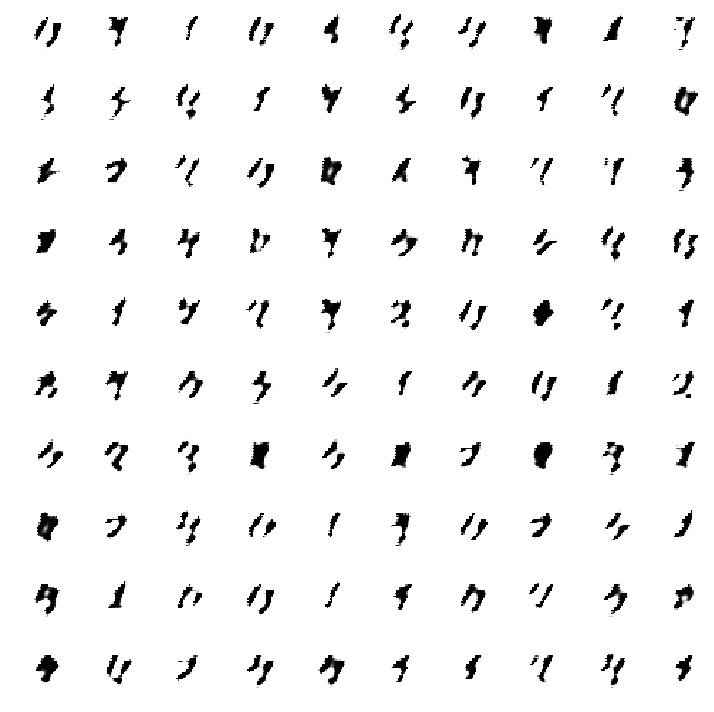

>2, 234/234, d=0.711, g=0.689
>3, 234/234, d=0.701, g=0.700
>4, 234/234, d=0.685, g=0.716
>5, 234/234, d=0.669, g=0.752
>6, 234/234, d=0.692, g=0.722
>7, 234/234, d=0.677, g=0.741
>8, 234/234, d=0.686, g=0.708
>9, 234/234, d=0.687, g=0.681
>10, 234/234, d=0.682, g=0.733
>Accuracy real: 64%, fake: 73%


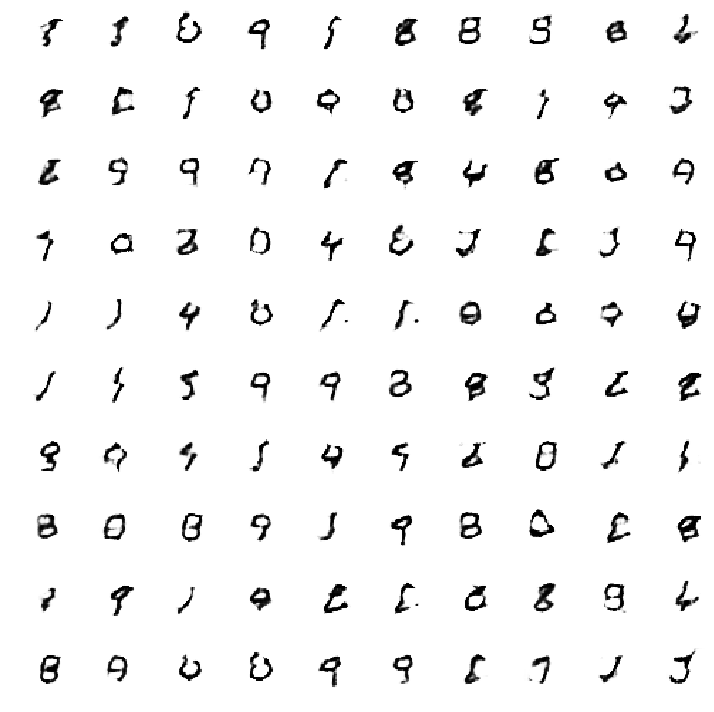

>11, 234/234, d=0.673, g=0.713
>12, 234/234, d=0.684, g=0.726
>13, 234/234, d=0.673, g=0.729
>14, 234/234, d=0.664, g=0.740
>15, 234/234, d=0.673, g=0.749
>16, 234/234, d=0.679, g=0.730
>17, 234/234, d=0.680, g=0.757
>18, 234/234, d=0.676, g=0.680
>19, 234/234, d=0.692, g=0.677
>20, 234/234, d=0.677, g=0.728
>Accuracy real: 59%, fake: 66%


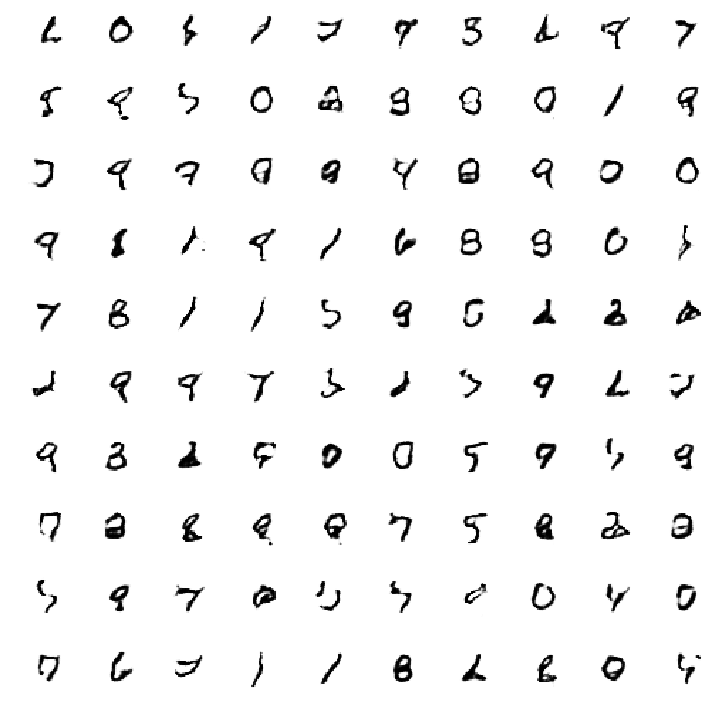

>21, 234/234, d=0.680, g=0.670
>22, 234/234, d=0.689, g=0.737
>23, 234/234, d=0.682, g=0.714
>24, 234/234, d=0.680, g=0.715
>25, 234/234, d=0.700, g=0.757
>26, 234/234, d=0.690, g=0.765
>27, 234/234, d=0.676, g=0.690
>28, 234/234, d=0.692, g=0.743
>29, 234/234, d=0.686, g=0.760
>30, 234/234, d=0.666, g=0.725
>Accuracy real: 66%, fake: 78%


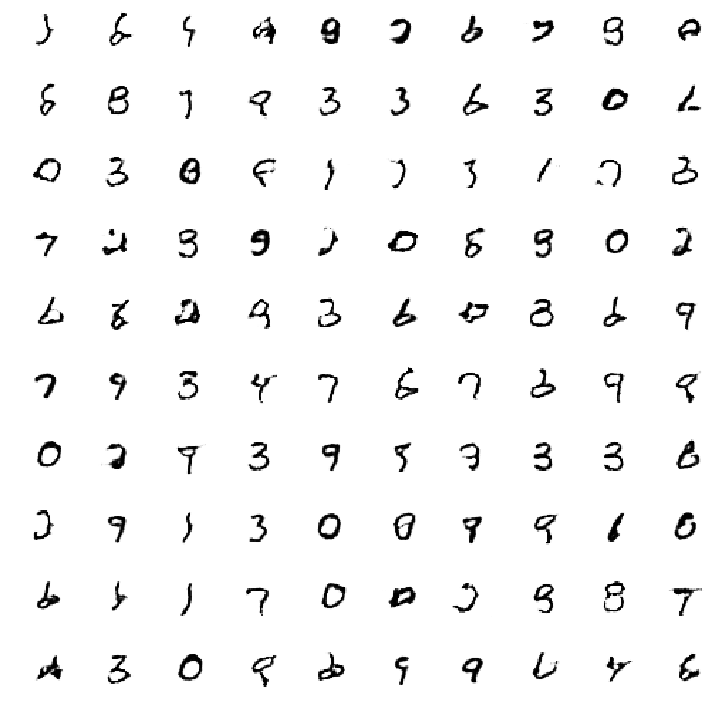

>31, 234/234, d=0.687, g=0.708
>32, 234/234, d=0.678, g=0.690
>33, 234/234, d=0.681, g=0.721
>34, 234/234, d=0.691, g=0.653
>35, 234/234, d=0.678, g=0.723
>36, 234/234, d=0.685, g=0.686
>37, 234/234, d=0.675, g=0.739
>38, 234/234, d=0.673, g=0.692
>39, 234/234, d=0.675, g=0.718
>40, 234/234, d=0.688, g=0.748
>Accuracy real: 36%, fake: 95%


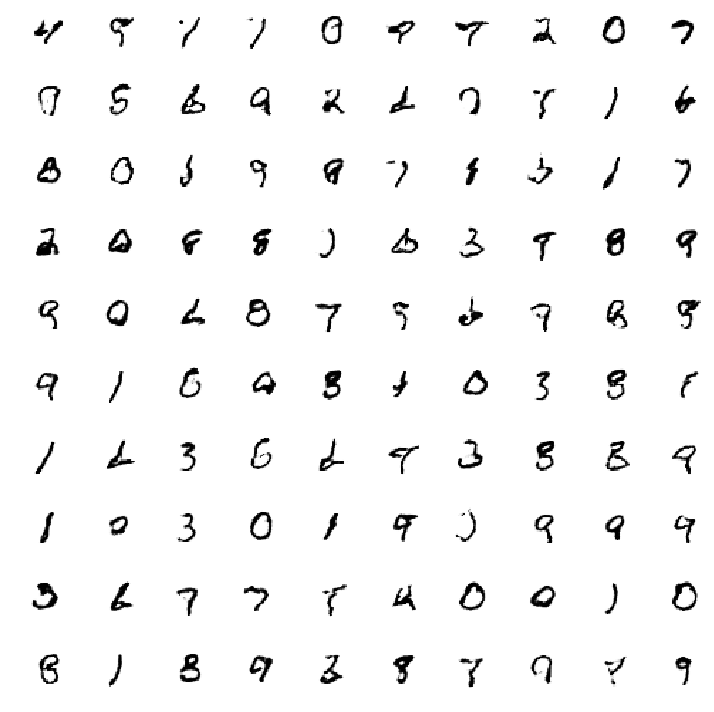

>41, 234/234, d=0.688, g=0.722
>42, 234/234, d=0.686, g=0.732
>43, 234/234, d=0.677, g=0.709
>44, 234/234, d=0.684, g=0.713
>45, 234/234, d=0.697, g=0.699
>46, 234/234, d=0.688, g=0.696
>47, 234/234, d=0.680, g=0.658
>48, 234/234, d=0.694, g=0.722
>49, 234/234, d=0.682, g=0.710
>50, 234/234, d=0.697, g=0.696
>Accuracy real: 59%, fake: 70%


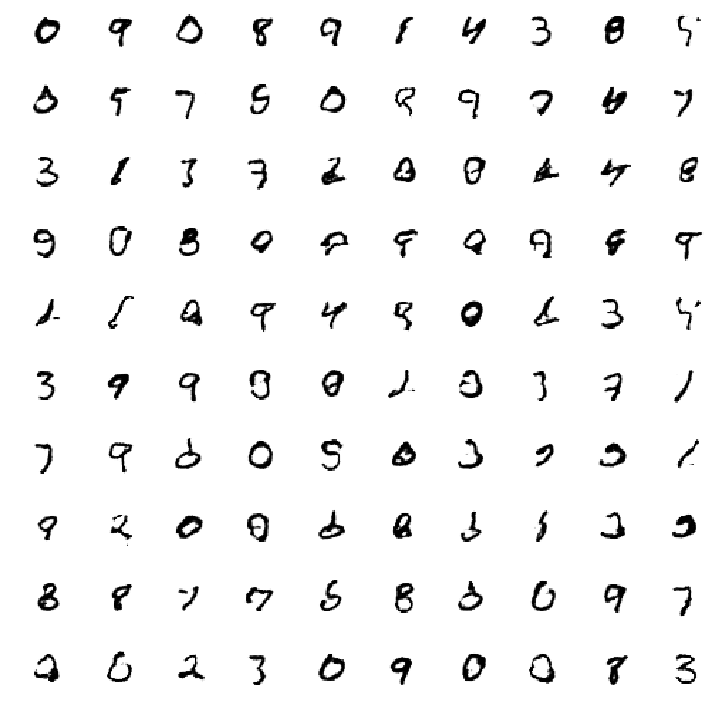

In [95]:
# setup
latent_dim = 5
optimiser = get_optimizer()
mnist_g_model = get_generator(latent_dim)
mnist_d_model = get_discriminator(optimiser)
mnist_gan_model = define_gan(mnist_g_model, mnist_d_model, optimiser)

# load image data
mnist_dataset = load_minst_data()

# train model
train('mnist', mnist_g_model, mnist_d_model, mnist_gan_model, mnist_dataset, latent_dim)

### Train Fashion MNIST

Dataset shape: (60000, 28, 28, 1)
>1, 234/234, d=0.686, g=0.713
>Accuracy real: 52%, fake: 43%


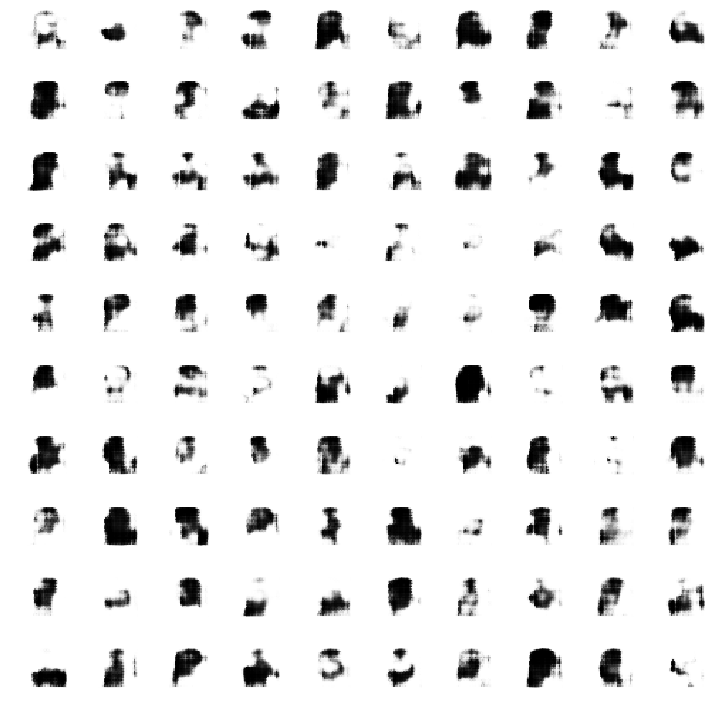

>2, 234/234, d=0.687, g=0.688
>3, 234/234, d=0.696, g=0.649
>4, 234/234, d=0.691, g=0.700
>5, 234/234, d=0.687, g=0.718
>6, 234/234, d=0.683, g=0.707
>7, 234/234, d=0.689, g=0.670
>8, 234/234, d=0.677, g=0.710
>9, 234/234, d=0.675, g=0.703
>10, 234/234, d=0.685, g=0.708
>Accuracy real: 59%, fake: 63%


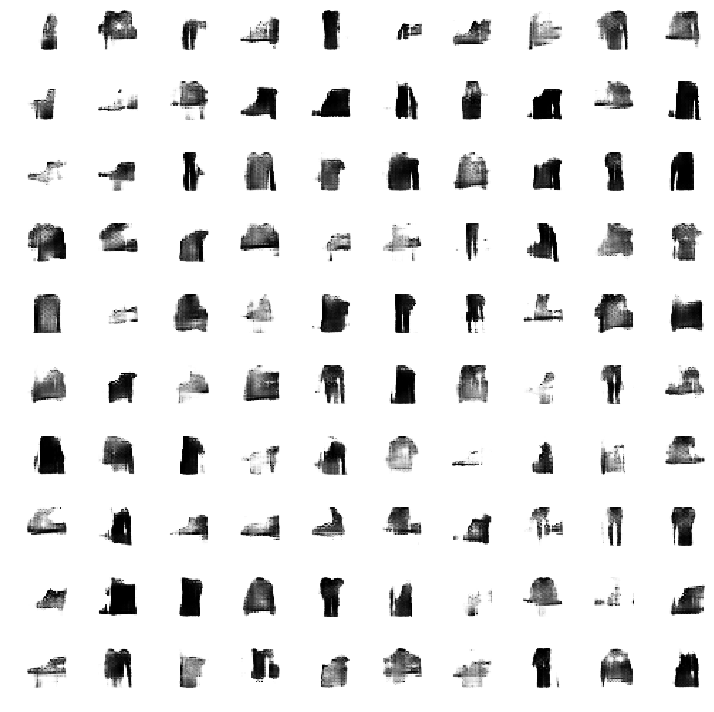

>11, 234/234, d=0.692, g=0.707
>12, 234/234, d=0.682, g=0.626
>13, 234/234, d=0.688, g=0.747
>14, 234/234, d=0.693, g=0.728
>15, 234/234, d=0.687, g=0.679
>16, 234/234, d=0.692, g=0.730
>17, 234/234, d=0.691, g=0.752
>18, 234/234, d=0.688, g=0.682
>19, 234/234, d=0.691, g=0.703
>20, 234/234, d=0.687, g=0.796
>Accuracy real: 12%, fake: 99%


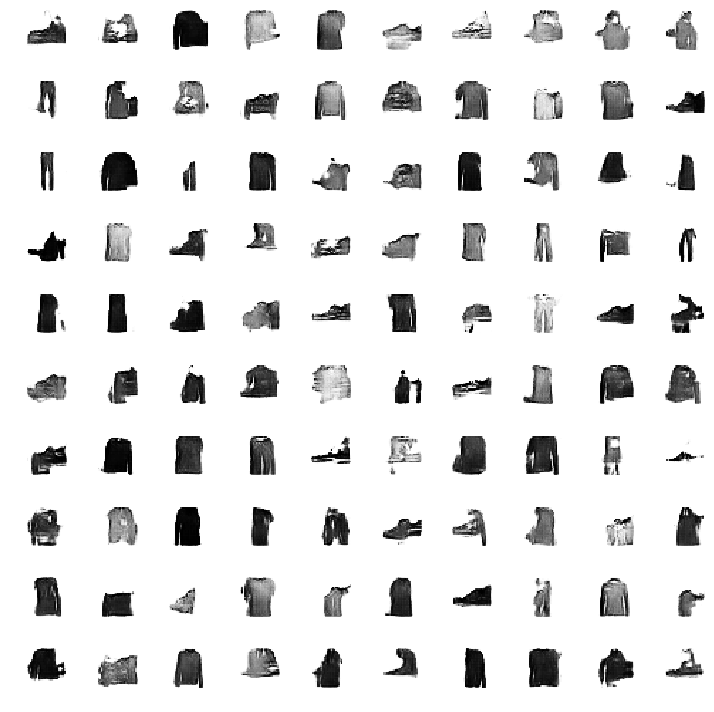

>21, 234/234, d=0.692, g=0.721
>22, 234/234, d=0.691, g=0.716
>23, 234/234, d=0.692, g=0.652
>24, 234/234, d=0.695, g=0.721
>25, 234/234, d=0.691, g=0.658
>26, 234/234, d=0.690, g=0.655
>27, 234/234, d=0.692, g=0.660
>28, 234/234, d=0.690, g=0.696
>29, 234/234, d=0.691, g=0.677
>30, 234/234, d=0.692, g=0.707
>Accuracy real: 44%, fake: 73%


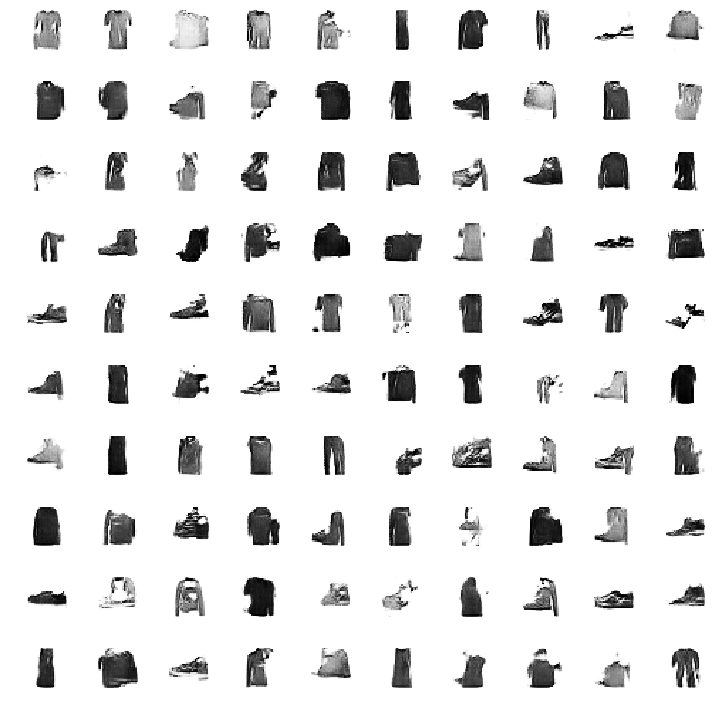

>31, 234/234, d=0.687, g=0.677
>32, 234/234, d=0.688, g=0.698
>33, 234/234, d=0.693, g=0.715
>34, 234/234, d=0.691, g=0.674
>35, 234/234, d=0.695, g=0.715
>36, 234/234, d=0.696, g=0.652
>37, 234/234, d=0.689, g=0.757
>38, 234/234, d=0.694, g=0.722
>39, 234/234, d=0.686, g=0.738
>40, 234/234, d=0.692, g=0.684
>Accuracy real: 94%, fake: 21%


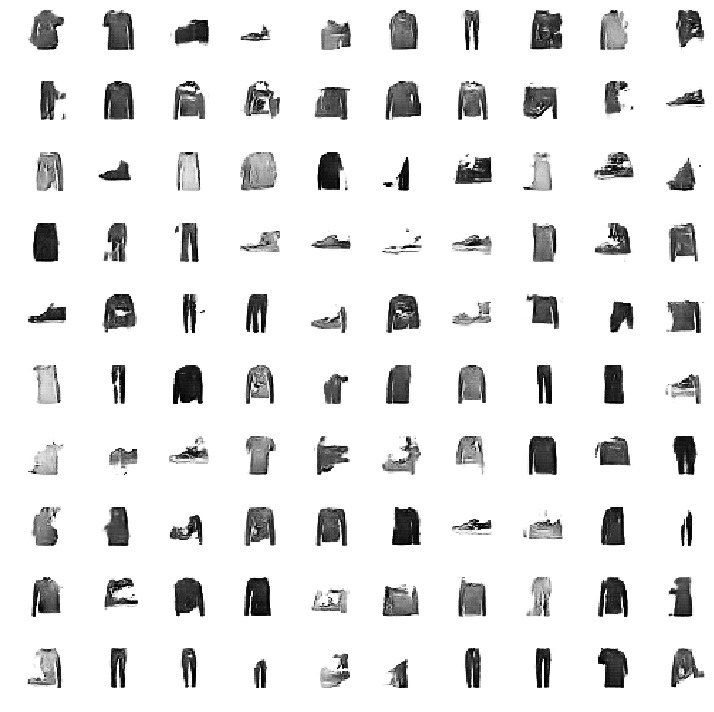

>41, 234/234, d=0.691, g=0.703
>42, 234/234, d=0.691, g=0.721
>43, 234/234, d=0.692, g=0.666
>44, 234/234, d=0.688, g=0.701
>45, 234/234, d=0.689, g=0.655
>46, 234/234, d=0.691, g=0.729
>47, 234/234, d=0.690, g=0.672
>48, 234/234, d=0.690, g=0.771
>49, 234/234, d=0.687, g=0.712
>50, 234/234, d=0.691, g=0.733
>Accuracy real: 4%, fake: 100%


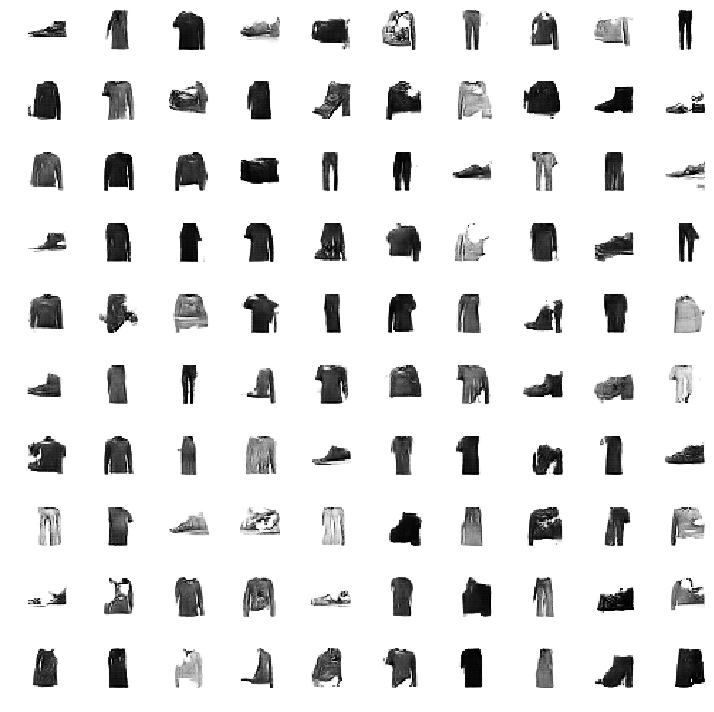

In [97]:
# setup
latent_dim = 100
optimiser = get_optimizer()
fmnist_g_model = get_generator(latent_dim)
fmnist_d_model = get_discriminator(optimiser)
fmnist_gan_model = define_gan(fmnist_g_model, fmnist_d_model, optimiser)

# load image data
fmnist_dataset = load_fashion_minst_data()

# train model
train('fmnist', fmnist_g_model, fmnist_d_model, fmnist_gan_model, fmnist_dataset, latent_dim)

### Train CIFAR 10

Dataset shape: (50000, 32, 32, 3)
>1, 195/195, d=0.706, g=0.765
>Accuracy real: 37%, fake: 73%


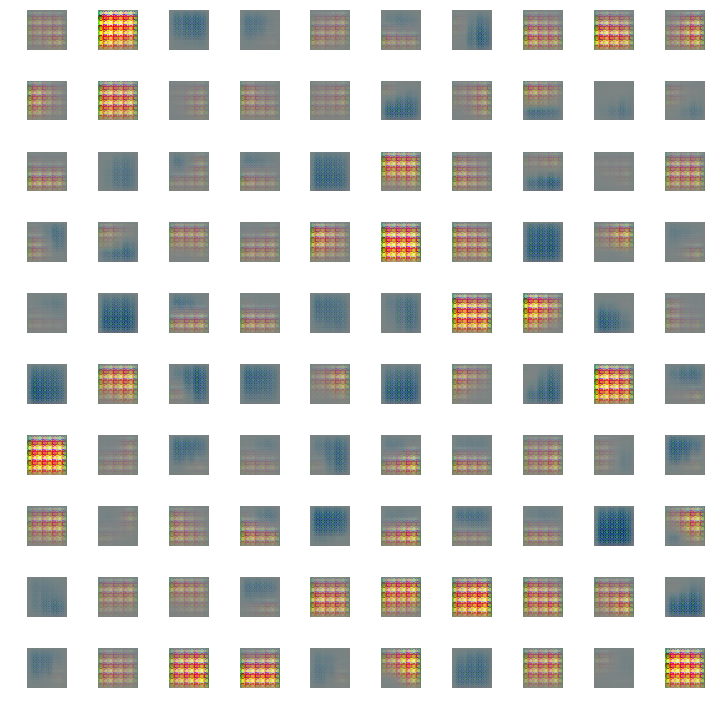

>2, 195/195, d=0.659, g=0.983
>3, 195/195, d=0.669, g=0.905
>4, 195/195, d=0.574, g=0.823
>5, 195/195, d=0.682, g=0.905
>6, 195/195, d=0.676, g=0.789
>7, 195/195, d=0.681, g=0.961
>8, 195/195, d=0.630, g=0.887
>9, 195/195, d=0.628, g=1.003
>10, 195/195, d=0.670, g=0.818
>Accuracy real: 81%, fake: 49%


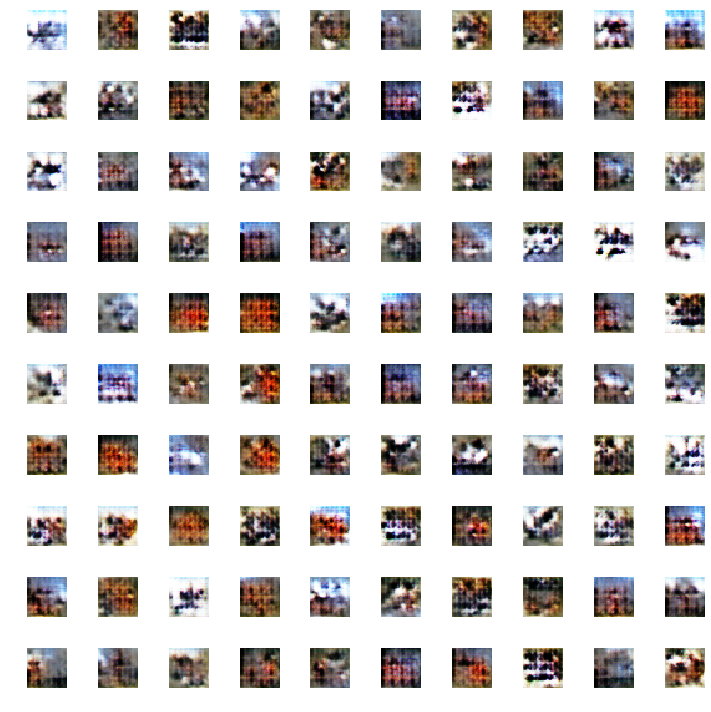

>11, 195/195, d=0.648, g=0.803
>12, 195/195, d=0.632, g=0.841
>13, 195/195, d=0.687, g=0.761
>14, 195/195, d=0.570, g=1.077
>15, 195/195, d=0.572, g=0.921
>16, 195/195, d=0.660, g=0.866
>17, 195/195, d=0.572, g=0.974
>18, 195/195, d=0.610, g=0.903
>19, 195/195, d=0.576, g=1.279
>20, 195/195, d=0.580, g=1.016
>Accuracy real: 58%, fake: 83%


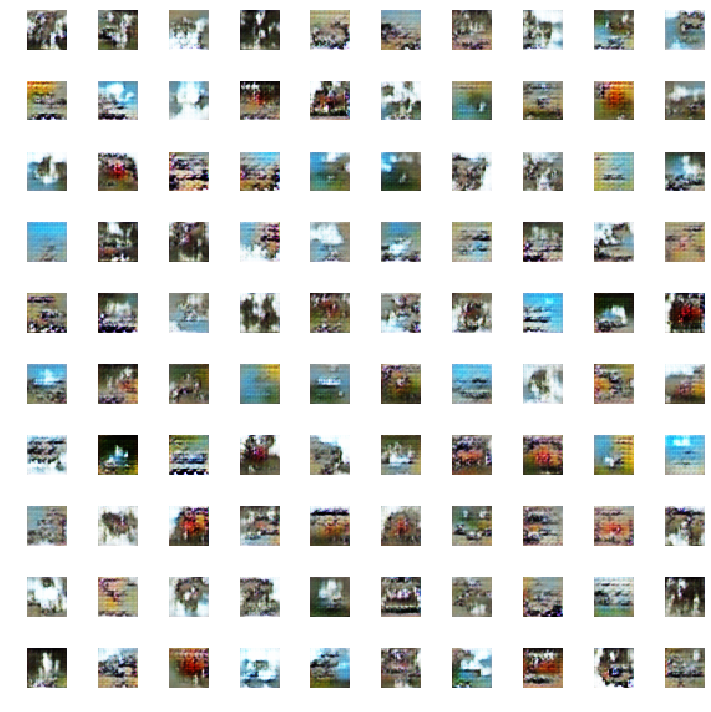

>21, 195/195, d=0.640, g=0.680
>22, 195/195, d=0.632, g=1.091
>23, 195/195, d=0.665, g=0.962
>24, 195/195, d=0.674, g=0.752
>25, 195/195, d=0.672, g=0.749
>26, 195/195, d=0.695, g=0.710
>27, 195/195, d=0.700, g=0.811
>28, 195/195, d=0.690, g=0.704
>29, 195/195, d=0.679, g=0.737
>30, 195/195, d=0.631, g=0.823
>Accuracy real: 61%, fake: 42%


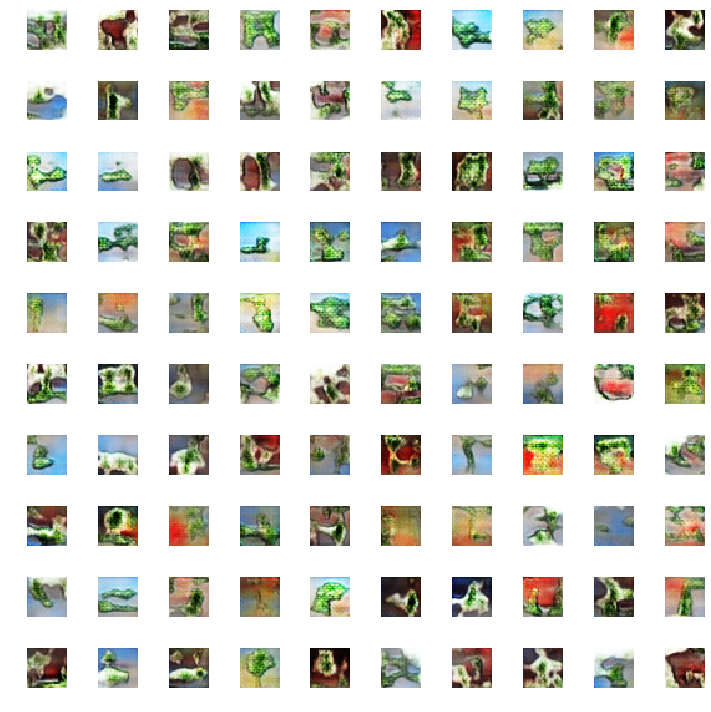

>31, 195/195, d=0.678, g=0.727
>32, 195/195, d=0.676, g=0.738
>33, 195/195, d=0.681, g=0.757
>34, 195/195, d=0.689, g=0.738
>35, 195/195, d=0.675, g=0.744
>36, 195/195, d=0.681, g=0.784
>37, 195/195, d=0.667, g=0.730
>38, 195/195, d=0.675, g=0.667
>39, 195/195, d=0.664, g=0.740
>40, 195/195, d=0.695, g=0.782
>Accuracy real: 32%, fake: 71%


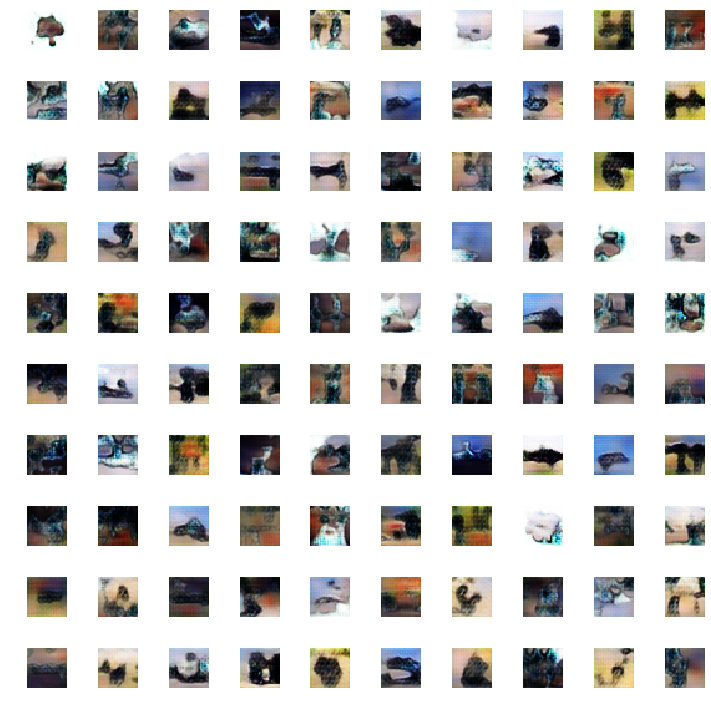

>41, 195/195, d=0.672, g=0.813
>42, 195/195, d=0.695, g=0.740
>43, 195/195, d=0.683, g=0.822
>44, 195/195, d=0.645, g=0.802
>45, 195/195, d=0.672, g=0.725
>46, 195/195, d=0.676, g=0.716
>47, 195/195, d=0.667, g=0.809
>48, 195/195, d=0.685, g=0.708
>49, 195/195, d=0.676, g=0.778
>50, 195/195, d=0.685, g=0.777
>Accuracy real: 40%, fake: 69%


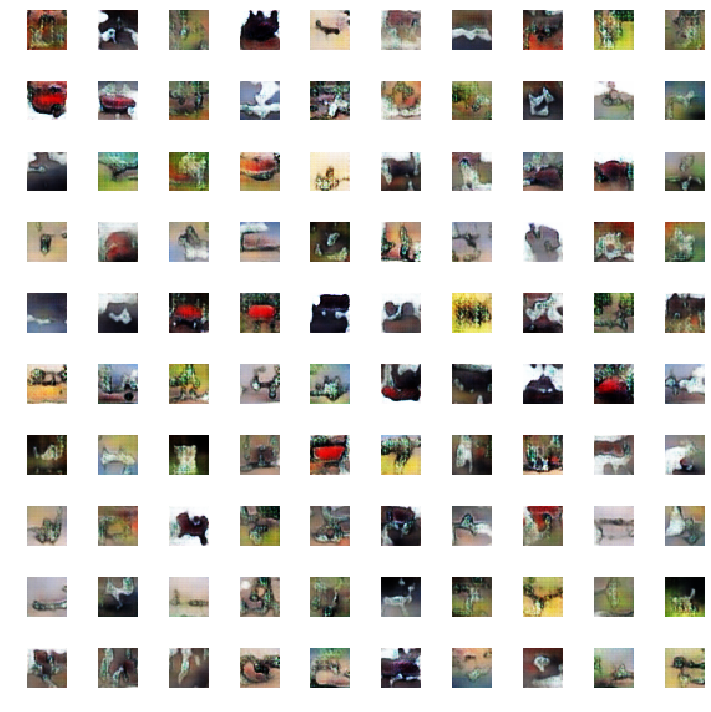

In [98]:
# setup
latent_dim = 100
optimiser = get_optimizer()
cifar10_g_model = get_generator_deeper(latent_dim)
cifar10_d_model = get_discriminator_deeper(optimiser)
cifar10_gan_model = define_gan(cifar10_g_model, cifar10_d_model, optimiser)

# load image data
cifar10_dataset = load_cifar10_data()

# train model
train('cifar10', cifar10_g_model, cifar10_d_model, cifar10_gan_model, cifar10_dataset, latent_dim)